## Portfolio Optimization using Genetic Algorithm

### Theoretical Approach for the Problem used:
Firstly, the data for the monthly closing stock values of MRF, Infosys, Reliance, Coal India, SBI and Titan are combined into a single dataframe. Historical returns for different periods ranging from 3 months to 36 months are then calculated for each of the stocks. The next step is to define the genetic algorithm terms - Gene and Chromosome. Gene is a scalar, which represents a fraction of the total capital assigned to a stock, whereas a Chromosome is a 1D array consisting of a set of genes, i.e., fractions of total capital assigned to each stock. It is essential to ensure that the sum of each chromosome is equal to one.

After defining the Gene and Chromosome, the next step is to generate an Initial Population, which is a 2D array consisting of randomly generated chromosomes. The fitness function is then defined, which calculates the Sharpe ratio, S. The Sharpe ratio is a measure that quantifies the performance of the portfolio by maximizing return and minimizing risk simultaneously. It is computed as the difference between the portfolio return and the risk-free rate, divided by the standard deviation of the returns. The fitness function uses the mean portfolio return, risk-free rate, and the standard deviation of the portfolio return to calculate the Sharpe ratio.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

np.random.seed(213)

### Combine the data into a single dataframe after reading it.

In [2]:
files=['MRF.csv','INFOSYS.csv','RELIANCE.csv','COAL.csv','SBI.csv','TITAN.csv']
dfs=[]
for file in files:
    temp=pd.read_csv("genetic_algo_data\\" + file)
    temp.columns=['Date',file.replace('.csv','')]
    dfs.append(temp)
stocks = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
print(stocks.shape)
stocks.head()

(37, 7)


,Date,MRF,INFOSYS,RELIANCE,COAL,SBI,TITAN
0,June 2018,2108.05,266.05,1271.3,896.80,560.55,1847.20
1,May 2018,2136.15,271.60,1367.6,923.50,480.15,1744.80
2,Apr 2018,1944.60,281.45,1400.6,872.65,528.15,1765.70
3,Mar 2018,1891.45,255.90,1311.9,740.20,495.40,1424.65
4,Feb 2018,1883.80,265.10,1319.1,728.75,535.35,1519.13


### Historical Returns for 3 months, 6 months, 12 months, 24 months and 36 months for each stock.

The calculation for the overall return of a stock involves adding the increase in its price with any dividends distributed and then dividing it by the initial price of the stock.

In [3]:
def hist_return(months):
    idx=[]
    df=pd.DataFrame()
    for mon in months:
        temp=(stocks.iloc[0,1:] - stocks.iloc[mon,1:])/(stocks.iloc[mon,1:])
        idx.append(str(mon)+' Month Return ')
        df=pd.concat([df, temp.to_frame().T], ignore_index=True)
    df.index=idx
    return df    

hist_stock_returns=hist_return([3,6,12,24,36])
hist_stock_returns

,MRF,INFOSYS,RELIANCE,COAL,SBI,TITAN
3 Month Return,0.114515,0.039664,-0.030947,0.211564,0.13151,0.296599
6 Month Return,0.125163,0.011212,0.011417,0.194062,-0.017957,0.368094
12 Month Return,0.275866,-0.178478,0.129783,0.330899,0.010911,0.562537
24 Month Return,0.792712,0.084237,0.274461,0.255179,-0.265911,0.44833
36 Month Return,0.974847,0.266844,0.069614,0.399938,-0.358785,0.447535


Define **Gene** (Scalar): A fraction of the total capital assigned to a stock. Lets address them as weights.

In [4]:
gene = np.random.rand()
gene

0.2184265373924411

Defining Chromosome (1D Array): Set of genes i.e. fractions of total capital assigned to each stock. Set of weights.

It is a 1D array consisting of fractional values representing each stock, with the sum of all fractions not exceeding 1. To create a chromosome, we will generate 6 fractional values, one for each company stock.

Why should the sum be equal to 1? This is because we assume that the total capital invested in the portfolio is 1 unit, and the fractional values represent the proportion of the total capital assigned to each stock.

To ensure that the sum equals 1, we can generate 6 random numbers and calculate a factor that is equal to 1 divided by the sum of these random numbers. Finally, we can multiply each of the generated random numbers with this factor, which will result in a sum of 1.

In [5]:
def chromosome(n):
    ch = np.random.rand(n)
    return ch/sum(ch)

child=chromosome(6)
print(child)
print("Sum = ", sum(child))

[0.21274846 0.21862272 0.13910761 0.1764979  0.16707693 0.08594639]
Sum =  1.0


Generating Initial Population

In [6]:
n=6 
pop_size=100 

population = np.array([chromosome(n) for _ in range(pop_size)])
print(population.shape)

(100, 6)


The fitness function is defined as the Sharpe ratio, which measures the performance of the portfolio. It is calculated using the following formula:

        S = (µ − r)/σ

where µ is the mean portfolio return over a specified period, r is the risk-free rate over the same period, and σ is the standard deviation of the returns over the specified period.

The mean portfolio return is calculated as the product of the mean return and the fractions of total capital assigned to each stock (chromosome).

The risk-free rate is set to 0.0697 (as per Google).

The standard deviation of the portfolio return is calculated as the square of the product of the chromosome and the standard deviation, plus the covariance of the respective weights in the chromosome.

Calculating Mean, Standard deviation and covariance of the Historical stock returns.

In [7]:
cols=hist_stock_returns.columns
hist_stock_returns[cols] = hist_stock_returns[cols].apply(pd.to_numeric, errors='coerce')

Covariance of returns

In [8]:
cov_hist_return=hist_stock_returns.cov()
for i in range(6):
    cov_hist_return.iloc[i][i]=0
    
cov_hist_return

,MRF,INFOSYS,RELIANCE,COAL,SBI,TITAN
MRF,0.000000,0.045393,0.027916,0.024127,-0.079078,0.014362
INFOSYS,0.045393,0.000000,-0.000718,0.004381,-0.023178,-0.005554
RELIANCE,0.027916,-0.000718,0.000000,0.002510,-0.013841,0.007330
COAL,0.024127,0.004381,0.002510,0.000000,-0.011042,0.005700
SBI,-0.079078,-0.023178,-0.013841,-0.011042,0.000000,-0.007211
TITAN,0.014362,-0.005554,0.007330,0.005700,-0.007211,0.000000


Mean of Returns

In [9]:
mean_hist_return=hist_stock_returns.mean()
print (mean_hist_return)

MRF         0.456621
INFOSYS     0.044696
RELIANCE    0.090865
COAL        0.278328
SBI        -0.100047
TITAN       0.424619
dtype: float64


Standard Deviation

In [10]:
sd_hist_return=hist_stock_returns.std()
print (sd_hist_return)

MRF         0.400340
INFOSYS     0.159583
RELIANCE    0.119189
COAL        0.086091
SBI         0.204405
TITAN       0.099615
dtype: float64


### Calculating Expected Portfolio Return and Portfolio Variance:

Expected Return

In [11]:
def mean_portfolio_return(child):
    return np.sum(np.multiply(child,mean_hist_return))

print("Expected Return = ", + mean_portfolio_return(population[0]))

def var_portfolio_return(child):
    part_1 = np.sum(np.multiply(child,sd_hist_return)**2)
    temp_lst=[]
    for i in range(6):
        for j in range(6):
            temp=cov_hist_return.iloc[i][j] * child[i] * child[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

print("Portfolio Variance = ", + var_portfolio_return(population[0]))

Expected Return =  0.22703800664335622
Portfolio Variance =  0.009391646174417649


Fitness Function

In [12]:
def fitness_fuction(child):
    rf= 0.0697 
    return (mean_portfolio_return(child)-rf)/np.sqrt(var_portfolio_return(child))

fitness_fuction(population[7])

0.9624719316364673

Defining a function that selects the elite population: it filters out the chromosomes with the highest returns, which were previously calculated in the fitness function.

In [13]:
def Select_elite_population(population, frac=0.3):
    population = sorted(population,key = lambda x: fitness_fuction(x),reverse=True)
    percentage_elite_idx = int(np.floor(len(population)* frac))
    return population[:percentage_elite_idx]

print(len(Select_elite_population(population, frac=0.3)))

[fitness_fuction(x) for x in population][:3]

30


[1.6235392128997435, 0.8112079699887221, 2.7144892701853713]

The mutation function performs changes to a chromosome. It selects two random numbers between 0 and 5, and then swaps the corresponding elements in the chromosome.

In [14]:
def mutation(parent):
    child=parent.copy()
    n=np.random.choice(range(6),2)
    while (n[0]==n[1]):
        n=np.random.choice(range(6),2)
    child[n[0]],child[n[1]]=child[n[1]],child[n[0]]
    return child

mutation(population[1]),population[1]

(array([0.33806557, 0.30934511, 0.14261774, 0.02814826, 0.12782655,
        0.05399677]),
 array([0.33806557, 0.30934511, 0.12782655, 0.02814826, 0.14261774,
        0.05399677]))

Crossover: The heuristic crossover, also known as blend crossover, uses the fitness values of two parent chromosomes to determine the direction of the search, moving from the worst parent to the best parent.

The offspring are generated using the following equation:

    Offspring A = Best Parent + β * (Best Parent − Worst Parent)
    Offspring B = Worst Parent - β * (Best Parent − Worst Parent)

Where β is a random number between 0 and 1. This type of crossover is effective for real-valued genomes.

In [15]:
def Heuristic_crossover(parent1,parent2):
    ff1=fitness_fuction(parent1)
    ff2=fitness_fuction(parent2)
    diff=parent1 - parent2
    beta=np.random.rand()
    if ff1>ff2:
        child1=parent1 + beta * diff
        child2=parent2 - beta * diff
    else:
        child2=parent1 + beta * diff
        child1=parent2 - beta * diff
    return child1,child2

A function that creates a new generation of chromosomes by performing mutation, mating, or crossover based on a given probability.

In [16]:
def next_generation(pop_size,elite,crossover=Heuristic_crossover):
    new_population=[]
    elite_range=range(len(elite))
    while len(new_population) < pop_size:
        if len(new_population) > 2*pop_size/3: 
            mutate_or_crossover = np.random.choice([0, 1], p=[0.9, 0.1])
        else:
            mutate_or_crossover = np.random.choice([0, 1], p=[0.6, 0.4])
        if mutate_or_crossover:
            indx=np.random.choice(elite_range)
            new_population.append(mutation(elite[indx]))
        else:
            p1_idx,p2_idx=np.random.choice(elite_range,2)
            c1,c2=crossover(elite[p1_idx],elite[p2_idx])
            new_population.extend([c1,c2])
    
    for i in range(len(new_population)):
        for j in range(6):
            if new_population[i][j] < 0:
                new_population[i][j] = 0
            if new_population[i][j] > 0.25:
                new_population[i][j] = 0.25

    for i in range(len(new_population)):
        temp = sum(new_population[i])
        for j in range(6):
            new_population[i][j] = new_population[i][j]/temp
    
    return new_population

elite=Select_elite_population(population)

The process of mutation, crossover, and selection of the next generation is repeated until there is no improvement in the maximum returns or minimum risk, or for a fixed number of iterations.

In [17]:
n=6 
pop_size=100 
population = np.array([chromosome(n) for _ in range(pop_size)])

elite = Select_elite_population(population)

iteration=0 
Expected_returns=0
Expected_risk=1
flag = 0

returns_list = []
risk_list = []

while (( (Expected_returns < 0.30 and Expected_risk > 0.0005) or iteration <= 100 ) and flag == 0):
    print('Iteration:',iteration)
    population = next_generation(100,elite)
    elite = Select_elite_population(population)
    Expected_returns=mean_portfolio_return(elite[0])
    Expected_risk=var_portfolio_return(elite[0])
    print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
    iteration+=1
    returns_list.append(Expected_returns)
    risk_list.append(Expected_risk)
    if(iteration==101):
        flag = 1

print('Optimal Solution Reached or Number of Maximum Iterations Reached')

Iteration: 0
Expected returns of 0.1647255259225422 with risk of 0.0005883255833192573

Iteration: 1
Expected returns of 0.1457191288821227 with risk of 0.00038860367623262584

Iteration: 2
Expected returns of 0.12129112534950803 with risk of 0.00013722067503819154

Iteration: 3
Expected returns of 0.13626724528012216 with risk of 0.00021337678736798368

Iteration: 4
Expected returns of 0.1305536916342295 with risk of 0.00014724973300781624

Iteration: 5
Expected returns of 0.13037369417577865 with risk of 0.0001637752677414719

Iteration: 6
Expected returns of 0.11786456060141648 with risk of 0.00013099600358106034

Iteration: 7
Expected returns of 0.15271949782557775 with risk of 0.00039713731143880583

Iteration: 8
Expected returns of 0.11810919886473972 with risk of 0.00012934885493966382

Iteration: 9
Expected returns of 0.14438914776424244 with risk of 0.0003198362014592759

Iteration: 10
Expected returns of 0.1526187305508163 with risk of 0.0004058638087353003

Iteration: 11
Exp

Expected returns of 0.137464326196039 with risk of 0.00022743035498665187

Iteration: 92
Expected returns of 0.13746440382267575 with risk of 0.00022743088576065735

Iteration: 93
Expected returns of 0.13746455840728564 with risk of 0.00022743193016806513

Iteration: 94
Expected returns of 0.13746411164697114 with risk of 0.00022742893655020371

Iteration: 95
Expected returns of 0.1374635617238612 with risk of 0.0002274252497826111

Iteration: 96
Expected returns of 0.13746378077395316 with risk of 0.00022742672330993124

Iteration: 97
Expected returns of 0.13746292601719987 with risk of 0.0002274209886807101

Iteration: 98
Expected returns of 0.13746472708150304 with risk of 0.00022743308042512227

Iteration: 99
Expected returns of 0.13746511979798215 with risk of 0.00022743571810380104

Iteration: 100
Expected returns of 0.13746514674698407 with risk of 0.00022743590030867202

Optimal Solution Reached or Number of Maximum Iterations Reached


Weights and their returns

Weight allotted to each stock under the constraints applied:

MRF : 0.0
INFOSYS : 0.2500000024536635
RELIANCE : 0.1303405189095002
COAL : 0.11965947372950926
SBI : 0.2500000024536635
TITAN : 0.2500000024536635

Expected returns of 13.746514674698407 % with risk of 0.00022743590030867202
 
Fitness Function Value =  4.4934185473549375


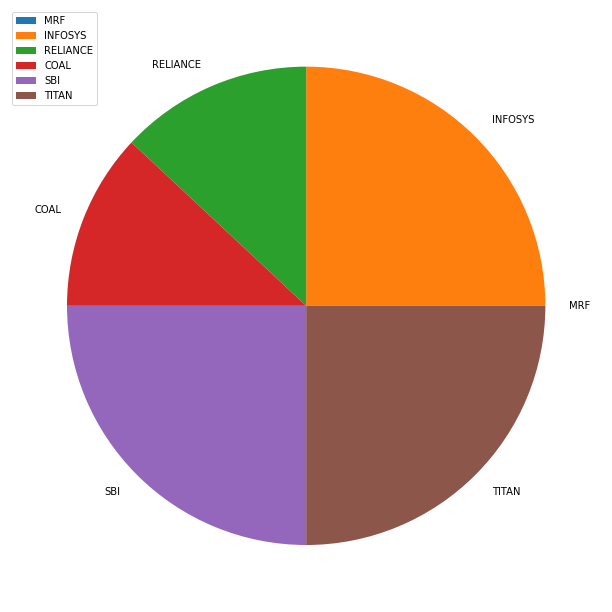

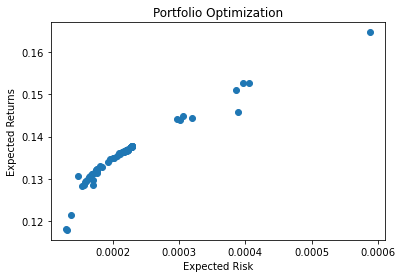

In [18]:
print('Weight allotted to each stock under the constraints applied:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

print('\nExpected returns of {} % with risk of {}\n '.format(Expected_returns*100,Expected_risk))

print("Fitness Function Value = ", + fitness_fuction(elite[5]))

plt.figure(figsize = (11,11))
plt.pie(elite[0], labels = hist_stock_returns.columns)
plt.legend()
plt.show()

plt.scatter(risk_list, returns_list)
plt.ylabel('Expected Returns')
plt.xlabel('Expected Risk')
plt.title('Portfolio Optimization')
plt.show()

The given process involves the creation of two offspring, represented as one-dimensional arrays, from two parent arrays. The offspring arrays are created using the following equations:

Offspring A = α * Parent1 + (1 - α) * Parent2

Offspring B = (1 - α) * Parent1 + α * Parent2

Here, the value of α is a randomly generated number between 0 and 1. The input to this process is two parent arrays, and the output is two offspring arrays, each represented as a one-dimensional array.

In [19]:
def Arithmetic_crossover(parent1,parent2):
    alpha = np.random.rand()
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1,child2

In [20]:
Arithmetic_crossover(population[2],population[3])
elite=Select_elite_population(population)
next_generation(100,elite,Arithmetic_crossover)[:3]

[array([0.        , 0.25      , 0.13034318, 0.11965682, 0.25      ,
        0.25      ]),
 array([0.        , 0.25      , 0.13034151, 0.11965849, 0.25      ,
        0.25      ]),
 array([0.        , 0.25      , 0.13034239, 0.1196576 , 0.25      ,
        0.25      ])]

In [21]:
n=6 
pop_size=100 
population = np.array([chromosome(n) for _ in range(pop_size)])
elite = Select_elite_population(population)

iteration=0 
Expected_returns=0
Expected_risk=1

returns_list = []
risk_list = []

while ( (Expected_returns < 0.30 and Expected_risk > 0.0005) and iteration <= 100 ):
    print('Iteration:',iteration)
    population = next_generation(100,elite, Arithmetic_crossover)
    elite = Select_elite_population(population)
    Expected_returns=mean_portfolio_return(elite[0])
    Expected_risk=var_portfolio_return(elite[0])
    print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
    iteration+=1
    returns_list.append(Expected_returns)
    risk_list.append(Expected_risk)


print('Optimal Solution Reached or Number of Maximum Iterations Reached')

Iteration: 0
Expected returns of 0.1723873410778412 with risk of 0.0007008506650635011

Iteration: 1
Expected returns of 0.17321552489901837 with risk of 0.0007633341893468135

Iteration: 2
Expected returns of 0.17566137736325688 with risk of 0.0007785159863450113

Iteration: 3
Expected returns of 0.1784214980994028 with risk of 0.0008197623171117257

Iteration: 4
Expected returns of 0.1777087423356016 with risk of 0.0008069669914216471

Iteration: 5
Expected returns of 0.17324298657355175 with risk of 0.0007345326107475406

Iteration: 6
Expected returns of 0.17556197104868432 with risk of 0.0007706113274808836

Iteration: 7
Expected returns of 0.17406683902259557 with risk of 0.0007472982990769737

Iteration: 8
Expected returns of 0.1741593620906317 with risk of 0.0007476910299046837

Iteration: 9
Expected returns of 0.17396080962508365 with risk of 0.0007445907885447172

Iteration: 10
Expected returns of 0.17418066491985978 with risk of 0.0007483754701209889

Iteration: 11
Expected r

Expected returns of 0.17376186163481966 with risk of 0.0007435591145509091

Iteration: 94
Expected returns of 0.17376186163481494 with risk of 0.0007435591145508623

Iteration: 95
Expected returns of 0.1737618616348114 with risk of 0.0007435591145508276

Iteration: 96
Expected returns of 0.17376186163480872 with risk of 0.0007435591145508007

Iteration: 97
Expected returns of 0.17376186163480678 with risk of 0.0007435591145507825

Iteration: 98
Expected returns of 0.17376186163480528 with risk of 0.000743559114550766

Iteration: 99
Expected returns of 0.17376186163480417 with risk of 0.0007435591145507538

Iteration: 100
Expected returns of 0.17376186163480328 with risk of 0.0007435591145507469

Optimal Solution Reached or Number of Maximum Iterations Reached


Weight allotted to each stock under the constraints applied:

MRF : 0.025296580594362062
INFOSYS : 0.19346191392594053
RELIANCE : 0.031241505479674223
COAL : 0.2500000000000077
SBI : 0.2500000000000077
TITAN : 0.2500000000000077

Expected returns of 17.376186163480327 % with risk of 0.0007435591145507469
 
Fitness Function Value =  3.8162238398548913


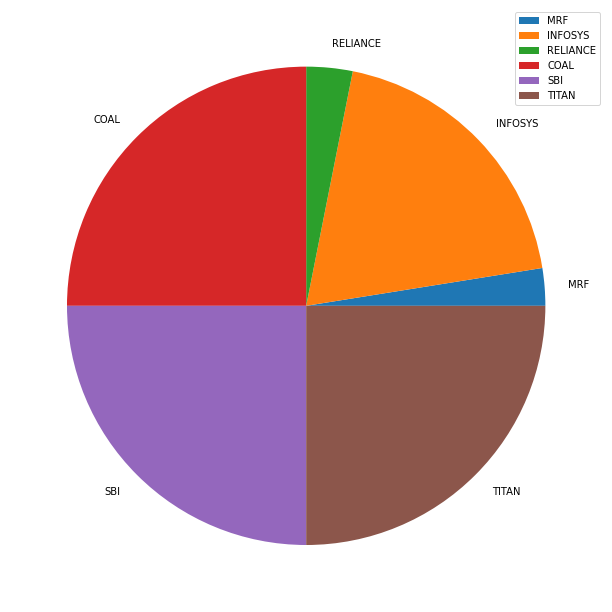

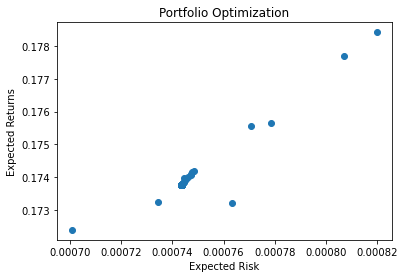

In [22]:
print('Weight allotted to each stock under the constraints applied:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

print('\nExpected returns of {} % with risk of {}\n '.format(Expected_returns*100,Expected_risk))

print("Fitness Function Value = ", + fitness_fuction(elite[5]))

plt.figure(figsize = (11,11))
plt.pie(elite[0], labels = hist_stock_returns.columns, normalize = False)
plt.legend()
plt.show()

plt.scatter(risk_list, returns_list)
plt.ylabel('Expected Returns')
plt.xlabel('Expected Risk')
plt.title('Portfolio Optimization')
plt.show()

### Comparision with MPT:

In [23]:
covariance = cov_hist_return.to_numpy()

In [24]:
covariance

array([[ 0.        ,  0.04539296,  0.02791593,  0.02412731, -0.07907816,
         0.01436192],
       [ 0.04539296,  0.        , -0.00071845,  0.00438124, -0.02317835,
        -0.0055536 ],
       [ 0.02791593, -0.00071845,  0.        ,  0.00250974, -0.0138409 ,
         0.00732976],
       [ 0.02412731,  0.00438124,  0.00250974,  0.        , -0.01104228,
         0.00569969],
       [-0.07907816, -0.02317835, -0.0138409 , -0.01104228,  0.        ,
        -0.00721078],
       [ 0.01436192, -0.0055536 ,  0.00732976,  0.00569969, -0.00721078,
         0.        ]])

Portfolio Expected Return: 8.833333333333332


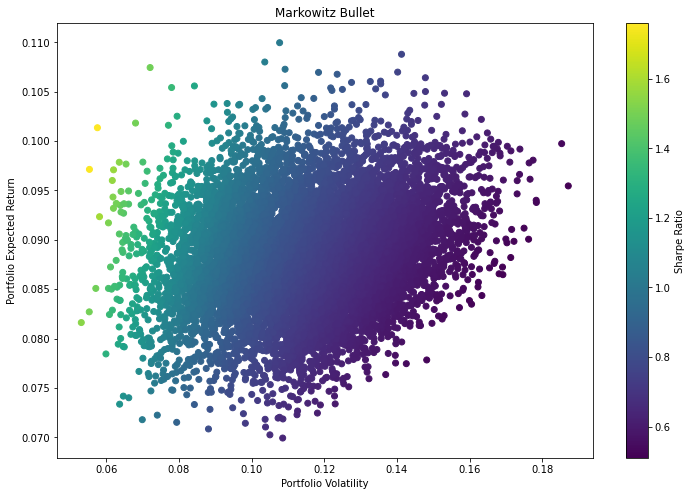

In [25]:
expected_returns = np.array([0.08, 0.12, 0.06, 0.09, 0.11, 0.07]) ### random returns
portfolio_weights = np.ones(len(expected_returns))/len(expected_returns)
portfolio_return = np.dot(expected_returns, portfolio_weights)
portfolio_variance = np.dot(np.dot(portfolio_weights, covariance), portfolio_weights)

print("Portfolio Expected Return:", portfolio_return*100)

num_portfolios = 10000
portfolio_returns = np.zeros(num_portfolios)
portfolio_variances = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    
    portfolio_returns[i] = np.dot(expected_returns, weights)
    portfolio_variances[i] = np.sqrt(np.dot(np.dot((weights), abs(covariance)), (weights)))
    
plt.figure(figsize=(12,8))
plt.scatter(portfolio_variances, portfolio_returns, c=portfolio_returns/portfolio_variances)
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Markowitz Bullet')
plt.show()